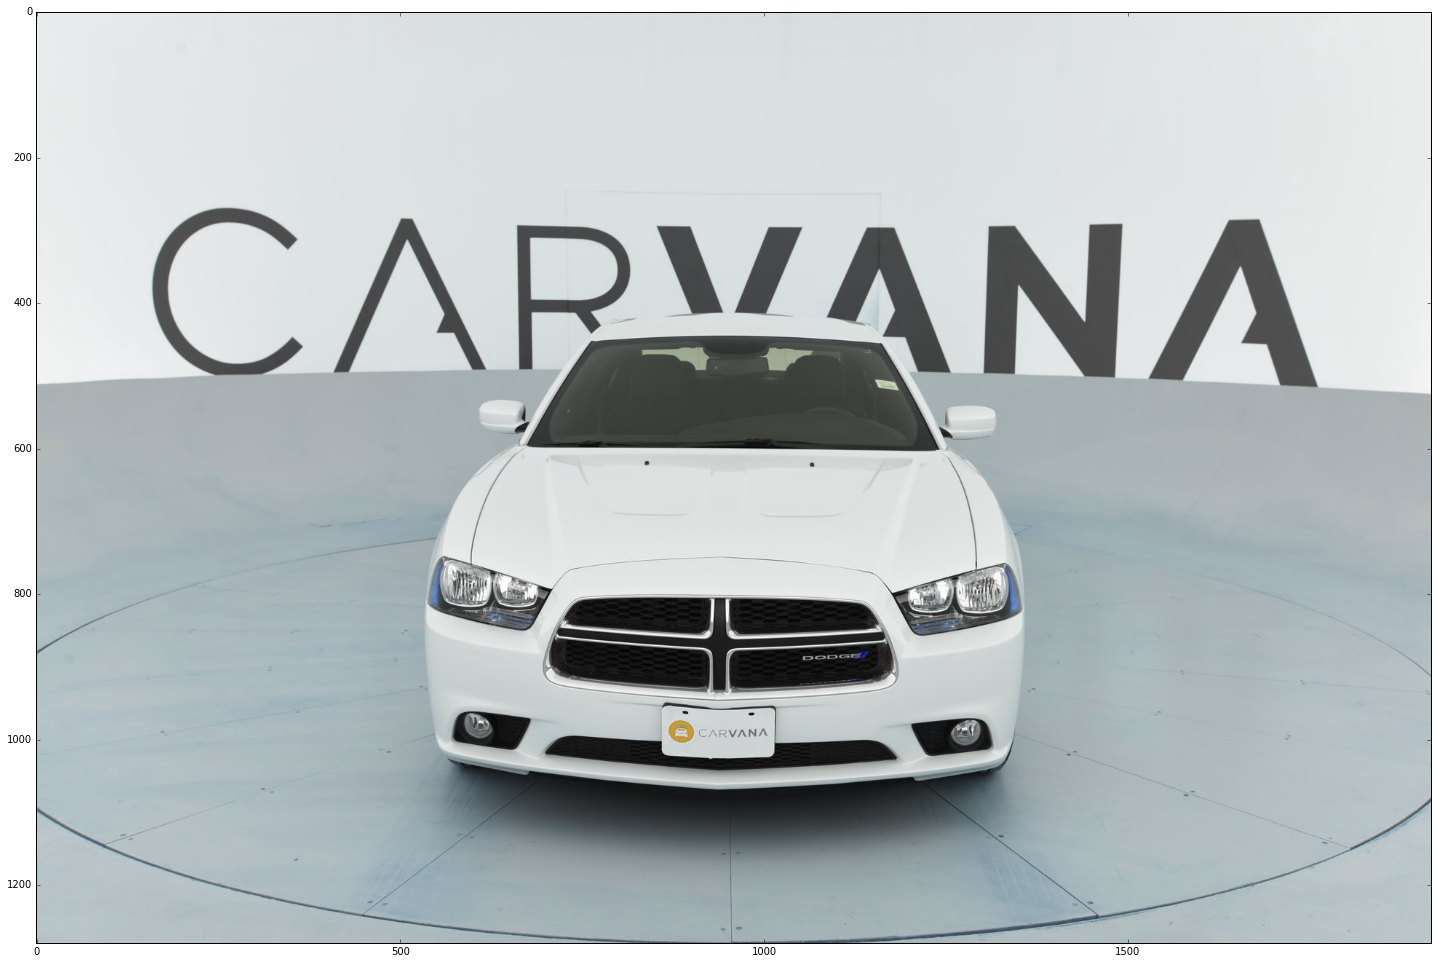

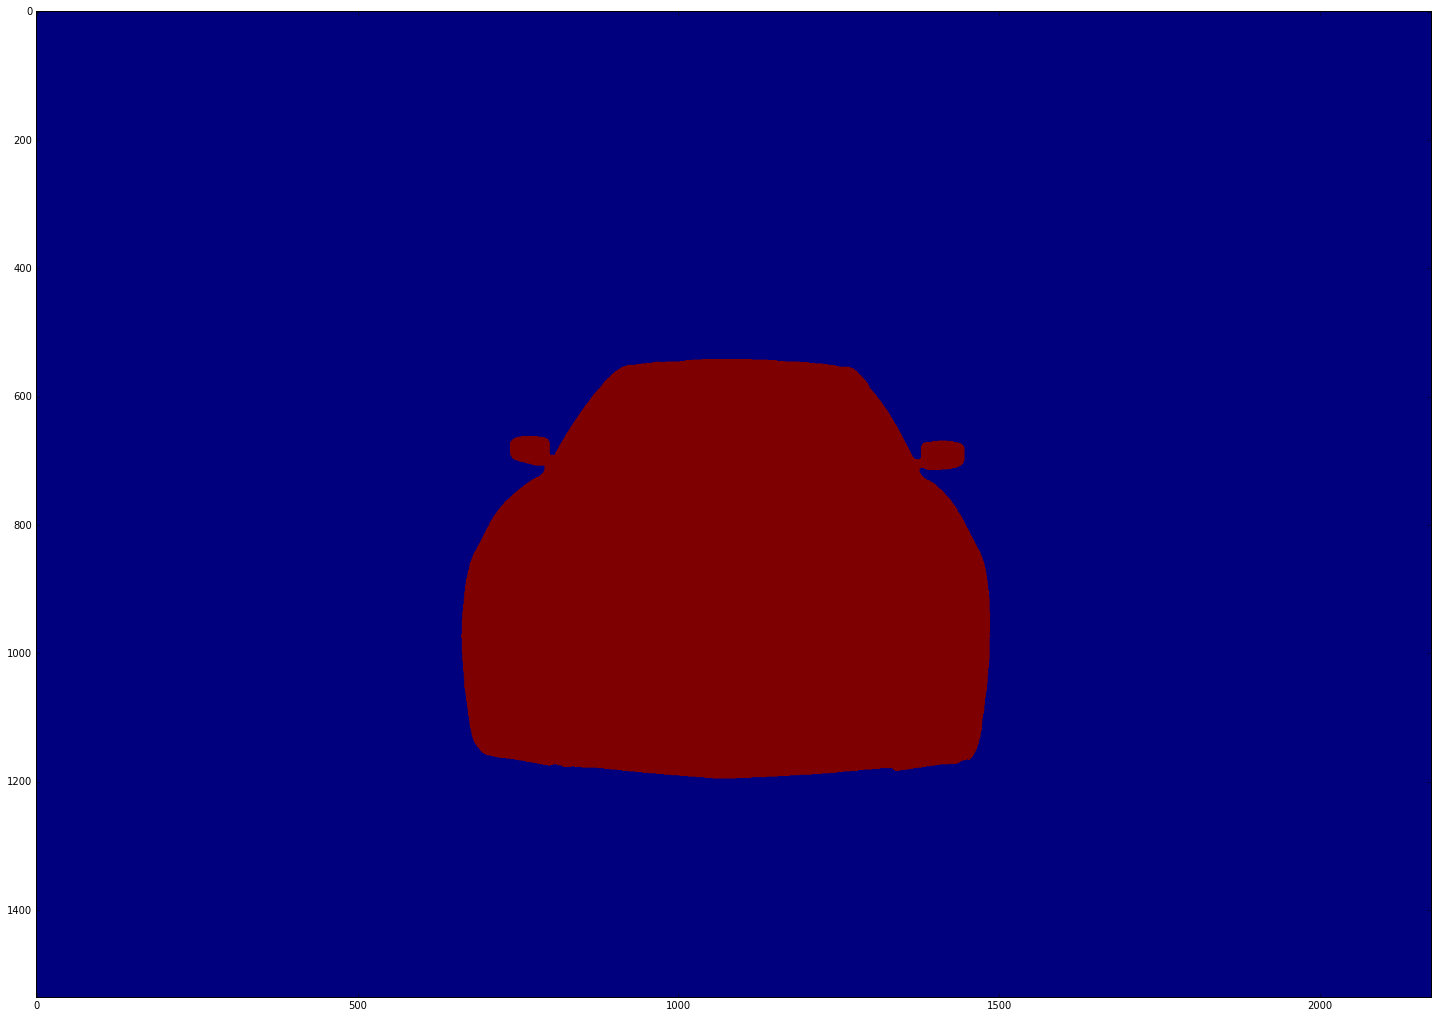

[[[218 223 224]
  [218 223 224]
  [218 223 224]
  ..., 
  [216 224 224]
  [216 224 224]
  [216 224 224]]

 [[218 223 224]
  [218 223 224]
  [218 223 224]
  ..., 
  [216 224 224]
  [216 224 224]
  [216 224 224]]

 [[218 223 224]
  [218 223 224]
  [218 223 224]
  ..., 
  [216 224 224]
  [216 224 224]
  [216 224 224]]

 ..., 
 [[ 62  66  61]
  [ 62  66  61]
  [ 61  65  60]
  ..., 
  [ 58  62  57]
  [ 58  62  57]
  [ 58  62  57]]

 [[ 62  66  61]
  [ 62  66  61]
  [ 61  65  60]
  ..., 
  [ 58  62  57]
  [ 58  62  57]
  [ 58  62  57]]

 [[ 62  66  61]
  [ 61  65  60]
  [ 61  65  60]
  ..., 
  [ 58  62  57]
  [ 58  62  57]
  [ 58  62  57]]]


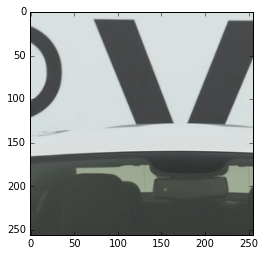

(256, 256, 3) [ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236] uint8


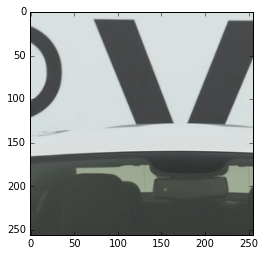

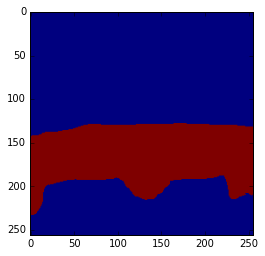

[[[218 223 224]
  [218 223 224]
  [218 223 224]
  ..., 
  [216 224 224]
  [216 224 224]
  [216 224 224]]

 [[218 223 224]
  [218 223 224]
  [218 223 224]
  ..., 
  [216 224 224]
  [216 224 224]
  [216 224 224]]

 [[218 223 224]
  [218 223 224]
  [218 223 224]
  ..., 
  [216 224 224]
  [216 224 224]
  [216 224 224]]

 ..., 
 [[ 62  66  61]
  [ 62  66  61]
  [ 61  65  60]
  ..., 
  [ 58  62  57]
  [ 58  62  57]
  [ 58  62  57]]

 [[ 62  66  61]
  [ 62  66  61]
  [ 61  65  60]
  ..., 
  [ 58  62  57]
  [ 58  62  57]
  [ 58  62  57]]

 [[ 62  66  61]
  [ 61  65  60]
  [ 61  65  60]
  ..., 
  [ 58  62  57]
  [ 58  62  57]
  [ 58  62  57]]]


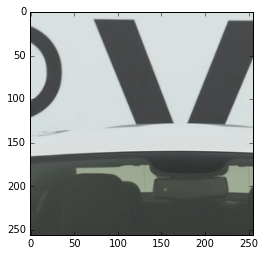

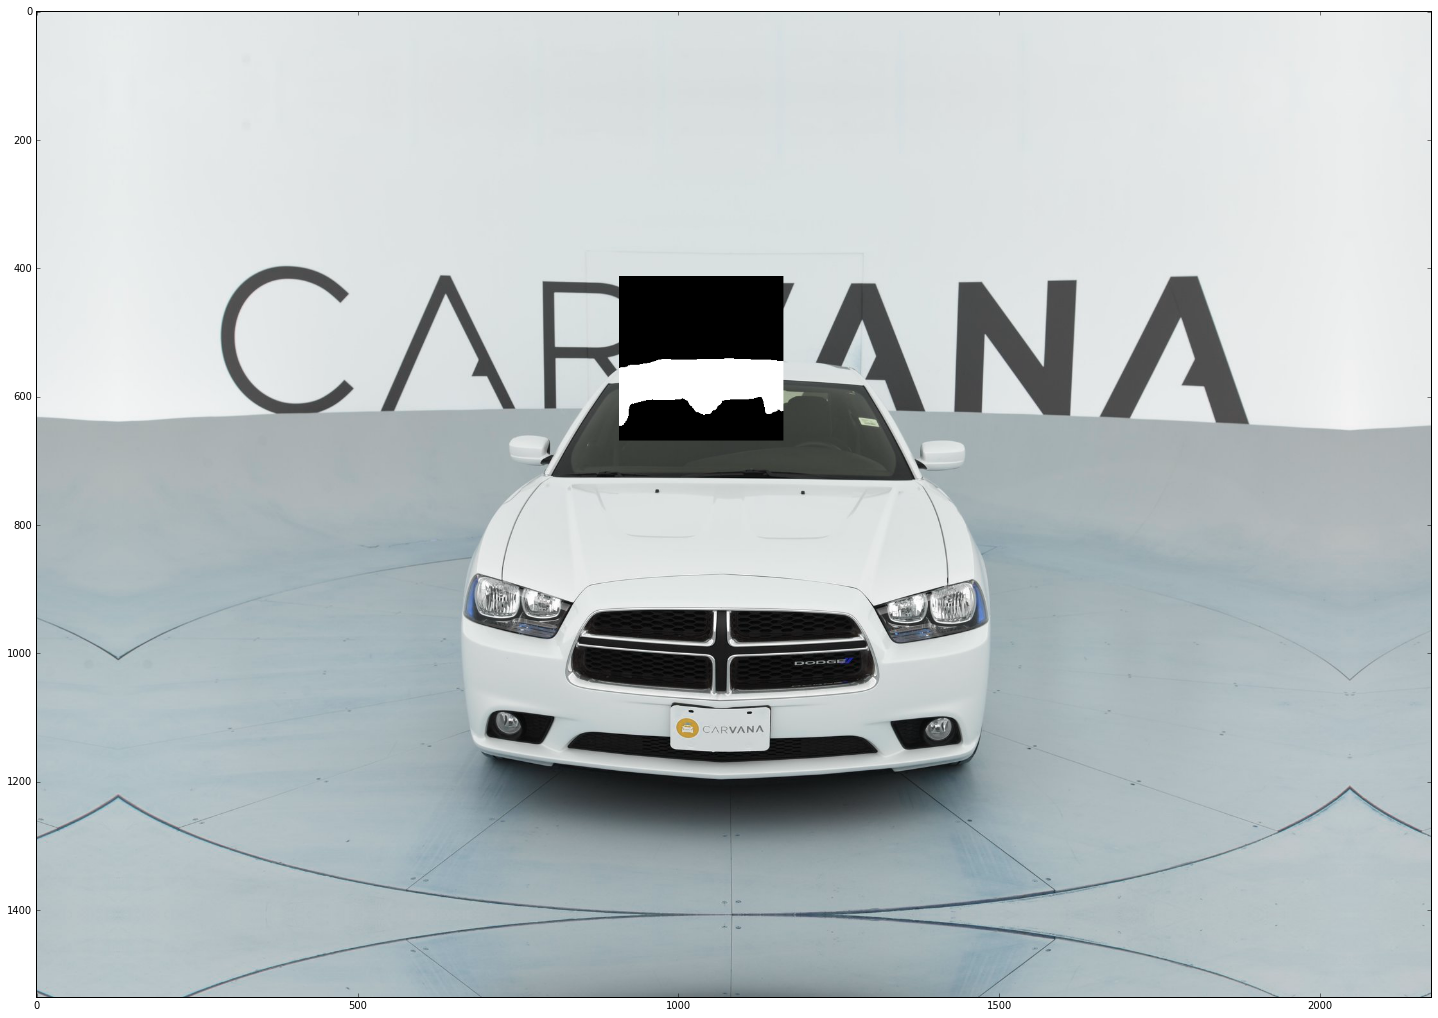

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import scipy.misc as misc
import os
from u_net import get_unet_128, get_unet_256
import copy

# patch size
N = 256
input_size = 256
batch_size = 32
threshold = 0.5
model = get_unet_256((input_size, input_size, 3))
model.load_weights(filepath='weights/patchesnet_unet256_noaug_sym_pad')


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


#with open("/data/pavel/fcn/DeepLab/unet2/submit/best_weights_skipcon_new_masks.csv") as csv:
with open("/home/antor/didi-ext/carvana/unet-s1-epoch83-val_dice_coef09969.csv") as csv:
    for x in csv:
        x = x.strip()

        if 'rle' in x:
            continue

        original_image = cv2.imread('/data/pavel/carv/test_hq/%s' % x.split(',')[0])
        img = original_image
        img = np.pad(img, ((N // 2, N // 2), (N // 2, N // 2), (0, 0)), 'symmetric')
        
        plt.figure(figsize=(25, 25))
        plt.imshow(original_image)
        plt.show()
        
        mask = rle_decode(x.split(',')[1], (1280, 1918))
        original_mask = mask
        mask = np.pad(mask, ((N // 2, N // 2), (N // 2, N // 2)), 'symmetric')
        
        plt.figure(figsize=(25, 25))
        plt.imshow(mask)
        plt.show()
        
        border = np.abs(np.gradient(mask)[1]) + np.abs(np.gradient(mask)[0])
        border = np.select([border == 0.5, border != 0.5], [1.0, border])
        
        height, width = mask.shape

        patches_img = []
        patches_loc = []

        i = 0
        for x, y in zip(np.nonzero(border)[0], np.nonzero(border)[1]):
            if i % 50 == 0 and x - N // 2 >= 0 and y - N // 2 >= 0:
                #cv2.rectangle(img,(y-N//2-1,x-N//2-1),(y+N//2,x+N//2),(255,255,0),1)
                patches_img.append(img[x - N // 2:x + N // 2, y - N // 2:y + N // 2, :])
                patches_loc.append([x - N // 2, x + N // 2, y - N // 2, y + N // 2])
            i = i + 1
            
        patches_img_copy = copy.deepcopy(patches_img)
        patch = patches_img_copy[0]
        print patch
        plt.imshow(patch)
        plt.show()
        
        def test_generator():
            while True:
                for start in range(0, len(patches_img), batch_size):
                    x_batch = []
                    end = min(start + batch_size, len(patches_img))
                    test_batch = patches_img[start:end]
                    for im in test_batch:
                        x_batch.append(im)
                    x_batch = np.array(x_batch, np.float32) / 255
                    yield x_batch
                    
        preds = model.predict_generator(generator=test_generator(),
                                    steps=np.ceil(float(len(patches_img)) / float(batch_size)))
        preds = np.squeeze(preds, axis=3)
        
        for i in xrange(len(preds)):
            pred = preds[i] > threshold
            loc = patches_loc[i]
            patch = patches_img_copy[i]
            
            pred = np.select([pred == True, pred == False], [np.array(255, dtype=np.uint8), np.array(0, dtype=np.uint8)])
            img[loc[0]:loc[1], loc[2]:loc[3],:] = np.dstack([pred,pred,pred])
            
            print patch.shape, np.unique(patch), patch.dtype
            plt.imshow(patch)
            plt.show()
            plt.imshow(pred)
            plt.show()
            
            break

        patch2 = patches_img_copy[0]
        print patch2
        plt.imshow(patch2)
        plt.show()
        
        plt.figure(figsize=(25, 25))
        plt.imshow(img)
        plt.show()
        
        break
